In [1]:
import pandas as pd
from ase.visualize import view as view_molecule
from ase.io import read as read_molecule
import ase
import numpy as np
import random
import networkx as nx
import walker


from ase.cell import Cell
from dscribe.descriptors import CoulombMatrix, SineMatrix, EwaldSumMatrix, SOAP

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy.linalg as LA
from sklearn.linear_model import LinearRegression
from numpy.linalg import inv
import seaborn as sns
from ase.geometry.analysis import Analysis

import warnings

warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = './nomad2018-predict-transparent-conductors'

In [3]:
train_data = pd.read_csv(f'{DATA_PATH}/train.csv')
test_data = pd.read_csv(f'{DATA_PATH}/test.csv')

In [4]:
def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            noise = np.array(
                [random.random()*0.001, random.random()*0.001, random.random()*0.001])
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=float)+noise, x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=float))
    return pos_data, np.array(lat_data)



In [5]:
def length(v):
    return np.linalg.norm(v)

def unit_vector(vector):
    return vector / length(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle_deg_between(v1, v2):
    return np.degrees(angle_between(v1, v2))

def get_lattice_constants(lattice_vectors):
    lat_const_series = pd.Series()
    for i in range(3):
        lat_const_series["lattice_vector_"+str(i+1)+"_ang"] = length(lattice_vectors[i])
    lat_const_series["lattice_angle_alpha_degree"] = angle_deg_between(lattice_vectors[1],lattice_vectors[2])
    lat_const_series["lattice_angle_beta_degree"] = angle_deg_between(lattice_vectors[2],lattice_vectors[0])
    lat_const_series["lattice_angle_gamma_degree"] = angle_deg_between(lattice_vectors[0],lattice_vectors[1])
    return lat_const_series

In [6]:
pos_data, lattice_vec_data = get_xyz_data(f'{DATA_PATH}/train/1/geometry.xyz')
atoms = [ase.Atom(symbol=sym, position=pos) for pos, sym in pos_data]
mol = ase.Atoms(atoms)
mol.set_cell(Cell(lattice_vec_data))

In [7]:
A = np.transpose(lattice_vec_data)
R = lattice_vec_data[0][0]
print("The lattice vectors:")
print(A)
print("The position vector:")
print(R)

The lattice vectors:
[[ 9.95208772e+00  4.03159900e-02  3.16403800e-02]
 [-4.72482400e-02  8.55117485e+00  9.66592000e-03]
 [-3.46579300e-02 -9.53377000e-03  9.17743912e+00]]
The position vector:
9.95208772


In [8]:
B = inv(A)
print("The reciprocal lattice vectors:")
print(B)

The reciprocal lattice vectors:
[[ 0.10047797 -0.00047411 -0.00034591]
 [ 0.00055475  0.11694024 -0.00012508]
 [ 0.00038002  0.00011969  0.10896142]]


In [9]:
def get_shortest_distances(reduced_coords, amat):
    natom = len(reduced_coords)
    dists = np.zeros((natom, natom))
    Rij_min = np.zeros((natom, natom, 3))

    for i in range(natom):
        for j in range(i):
            rij = reduced_coords[i][0] - reduced_coords[j][0]
            d_min = np.inf
            R_min = np.zeros(3)
            for l in range(-1, 2):
                for m in range(-1, 2):
                    for n in range(-1, 2):
                        r = rij + np.array([l, m, n])
                        R = np.matmul(amat, r)
                        d = length(R)
                        if d < d_min:
                            d_min = d
                            R_min = R
            dists[i, j] = d_min
            dists[j, i] = dists[i, j]
            Rij_min[i, j] = R_min
            Rij_min[j, i] = -Rij_min[i, j]
    return dists, Rij_min

In [10]:
crystal_red = [[np.matmul(B, R), symbol] for (R, symbol) in pos_data]
crystal_dist, crystal_Rij = get_shortest_distances(crystal_red, A)

<AxesSubplot:>

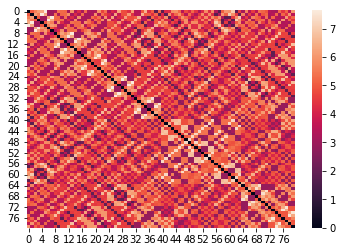

In [11]:
sns.heatmap(crystal_dist)

In [12]:
natom = len(crystal_red)
al_atoms = [i for i in range(natom) if crystal_red[i][1] == 'Al']
ga_atoms = [i for i in range(natom) if crystal_red[i][1] == 'Ga']
in_atoms = [i for i in range(natom) if crystal_red[i][1] == 'In']
o_atoms = [i for i in range(natom) if crystal_red[i][1] == 'O']

In [13]:
def get_distances(r, amat, l_max=3, m_max=3, n_max=3, R_max=20.0):
    distances = []
    for l in range(-l_max, l_max+1):
        for m in range(-m_max, m_max+1):
            for n in range(-n_max, n_max+1):
                R = np.matmul(amat, r + np.array([l, m, n]))
                d = length(R)
                if d < R_max:
                    distances.append(d)
                    
    return distances

In [14]:
def get_optimal_lmn(bmat, R_max=20.0):
    lmn = dict()
    lmn["l_max"] = int(length(bmat[0]) * R_max) + 1
    lmn["m_max"] = int(length(bmat[1]) * R_max) + 1
    lmn["n_max"] = int(length(bmat[2]) * R_max) + 1
    lmn["R_max"] = R_max

    return lmn

opt_lmn = get_optimal_lmn(B)

print(opt_lmn)


{'l_max': 3, 'm_max': 3, 'n_max': 3, 'R_max': 20.0}


In [15]:
natom = len(crystal_red)
m_atoms = [i for i in range(natom) if crystal_red[i][1] != 'O']
o_atoms = [i for i in range(natom) if crystal_red[i][1] == 'O']

m_o_distances = []
for i in m_atoms:
    for j in o_atoms:
        rij = np.matmul(B, crystal_Rij[i, j])
        m_o_distances += get_distances(rij, A, **opt_lmn)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   16.,
          96.,   48.,   16.,    0.,    0.,    0.,   16.,   64.,  133.,
          99.,   24.,   24.,   96.,  282.,  182.,   24.,   48.,   96.,
         110.,   67.,  183.,  352.,  232.,  144.,  344.,  184.,  208.,
         328.,  274.,  189.,  322.,  247.,  352.,  365.,  329.,  455.,
         443.,  686.,  450.,  264.,  392.,  472.,  480.,  594.,  633.,
         789.,  464.,  432.,  656.,  785.,  887.,  836.,  572.,  664.,
         665.,  834.,  906.,  835.,  999., 1137.,  788., 1019., 1049.,
        1134.,  938., 1032.,  992., 1110., 1439., 1276., 1184., 1207.,
        1191., 1564., 1623., 1337., 1186., 1236., 1442., 1935., 1718.,
        1381., 1742., 1733., 1672., 1655., 1911., 2045., 1829., 1659.,
        1895.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8

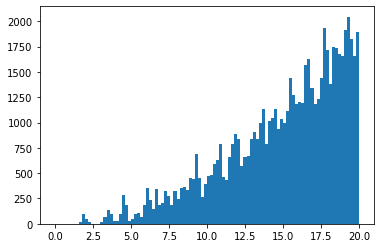

In [16]:
plt.hist(m_o_distances, bins=100, range=(0, 20))

# Graph
ngrams are walks of length n
- crystal graph
- path graph

In [17]:
analysis = Analysis(mol)

In [18]:
analysis.all_bonds[0]

[[6, 38, 62],
 [39, 56, 63],
 [4, 36, 59, 60],
 [5, 37, 61],
 [2, 34, 58, 60],
 [3, 35, 44, 59, 61],
 [0, 32, 47, 56, 62],
 [33, 57, 63],
 [48, 54],
 [44, 49, 55],
 [12, 13, 20, 21, 35, 36, 47, 50, 52, 76],
 [13, 21, 37, 51, 53, 77],
 [10, 34, 36, 40, 52],
 [10, 11, 35, 37, 41, 50, 53],
 [32, 38],
 [33, 39],
 [64],
 [65, 72],
 [56, 66, 75],
 [57, 67],
 [10, 34, 46, 52, 62, 68, 76],
 [10, 11, 35, 47, 53, 63, 69, 77],
 [32, 70, 78],
 [33, 71, 79],
 [30, 31, 40, 50, 52, 64, 70, 72],
 [31, 41, 51, 53, 65, 71, 73],
 [28, 42, 48, 54, 66, 68, 74],
 [28, 29, 43, 49, 55, 67, 69, 75],
 [26, 27, 44, 49, 54, 66, 69, 76],
 [27, 45, 55, 67, 77],
 [24, 46, 52, 64, 78],
 [24, 25, 47, 50, 53, 65, 70, 79],
 [6, 14, 22],
 [7, 15, 23],
 [4, 12, 20],
 [5, 10, 13, 21],
 [2, 10, 12],
 [3, 11, 13],
 [0, 14],
 [1, 15],
 [12, 24],
 [13, 25],
 [26],
 [27],
 [5, 9, 28],
 [29],
 [20, 30],
 [6, 10, 21, 31],
 [8, 26],
 [9, 27, 28],
 [10, 13, 24, 31],
 [11, 25],
 [10, 12, 20, 24, 30],
 [11, 13, 21, 25, 31],
 [8, 26, 

In [19]:
mol.get_atomic_numbers()

array([31, 13, 13, 31, 31, 13, 13, 13, 13, 31, 31, 13, 13, 31, 13, 31, 31,
       13, 31, 13, 31, 13, 13, 13, 31, 13, 13, 13, 13, 31, 13, 13,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])

In [20]:
mol.symbols.index('Al')

1

In [21]:
G = nx.Graph()
# nodes
nodes = []
for i, atom in enumerate(mol.symbols):
    nodes.append((i,{'name':atom}))
G.add_nodes_from(nodes)
# edges
edges = []
for i, bonds in enumerate(Analysis(mol).all_bonds[0]):
    for b in bonds:
        edges.append((i,b))

G.add_edges_from(edges)


In [22]:
print(G)

Graph with 80 nodes and 137 edges


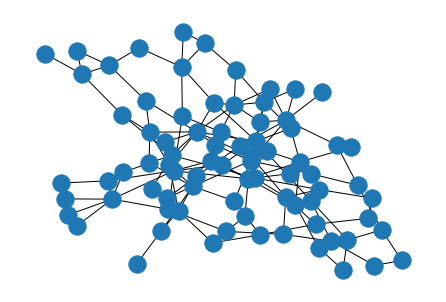

In [23]:
nx.draw(G)

In [25]:
walker.random_walks(G, n_walks=15, walk_len=10)

Random walks - T=0.01s


array([[ 0, 38,  0, ..., 20, 52, 10],
       [ 1, 63,  7, ..., 67, 29, 67],
       [ 2, 59,  5, ...,  5, 35, 13],
       ...,
       [77, 29, 77, ..., 19, 67, 19],
       [78, 22, 78, ..., 16, 64, 24],
       [79, 23, 71, ..., 63,  1, 56]], dtype=uint32)